In [60]:
import os
import time 
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
import os
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import logging
import warnings

warnings.filterwarnings('ignore')

In [61]:
train = pd.read_csv("d:/tianchi/happiness/happiness_train_complete.csv", parse_dates=['survey_time'], encoding='latin-1') 
test = pd.read_csv("d:/tianchi/happiness/happiness_test_complete.csv", parse_dates=['survey_time'], encoding='latin-1')
train = train[train["happiness"]!=-8].reset_index(drop=True)
train_data_copy = train.copy()
target_col = "happiness"
target = train_data_copy[target_col]
del train_data_copy[target_col]

data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

In [62]:
train.happiness.describe()

count    7988.000000
mean        3.867927
std         0.818717
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7988 entries, 0 to 7987
Columns: 140 entries, id to public_service_9
dtypes: datetime64[ns](1), float64(25), int64(111), object(3)
memory usage: 8.5+ MB


In [33]:
# 查看每个特征的缺失情况
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
edu_other,10950,0.999452
invest_other,10911,0.995893
property_other,10867,0.991877
join_party,9831,0.897317
s_work_type,7437,0.678806
s_work_status,7437,0.678806
work_status,6932,0.632713
work_yr,6932,0.632713
work_manage,6931,0.632621
work_type,6931,0.632621


In [34]:
train.happiness.value_counts()

4    4818
5    1410
3    1159
2     497
1     104
Name: happiness, dtype: int64

In [63]:
#make feature 139 +5 = 144
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])

#调查问卷有效程度
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)




In [8]:
train.happiness.describe()

count    8000.000000
mean        3.868125
std         0.818118
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: happiness, dtype: float64

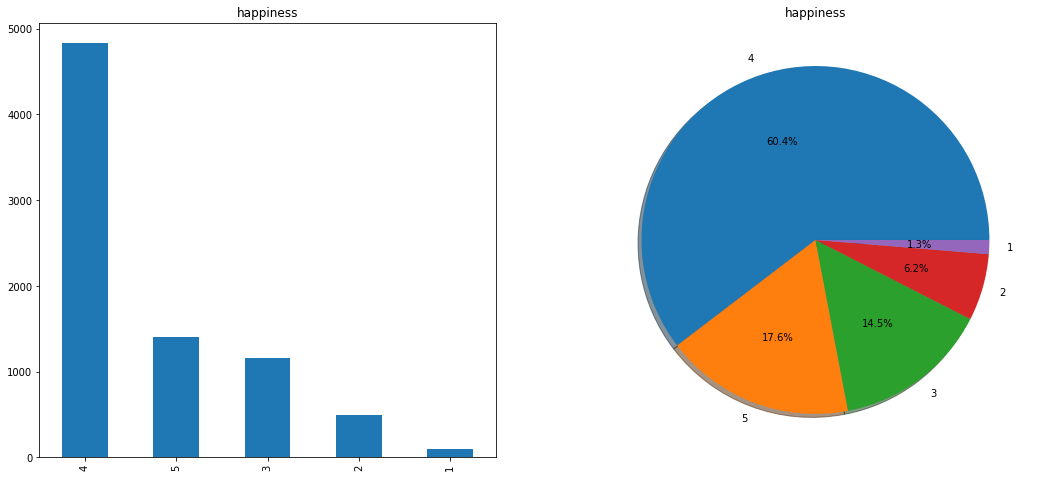

In [25]:
# 查看各个类别的分布情况
f,ax=plt.subplots(1,2,figsize=(18,8))
train['happiness'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('happiness')
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('happiness')
ax[1].set_ylabel('')
plt.show()

Text(0.5, 1, 'surver_type:happiness')

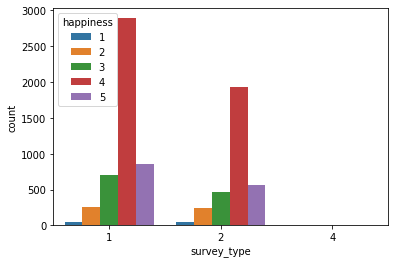

In [26]:
# 探究样本类型（1:城市或2:农村）和幸福感的分布
sns.countplot('survey_type',hue='happiness',data=train)
ax[1].set_title('surver_type:happiness')

Text(0.5, 1, 'Sex:happiness')

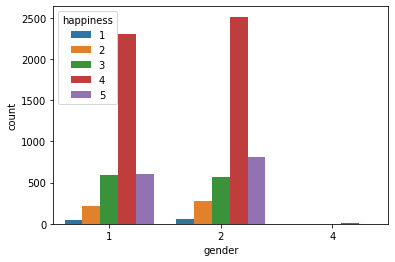

In [27]:
# 探究性别(1:男 2：女)和幸福感的分布
sns.countplot('gender',hue='happiness',data=train)
ax[1].set_title('Sex:happiness')

In [64]:
#填充缺失值 共25列 去掉4列 填充21列

data['work_status'] = data['work_status'].fillna(0)
data['work_yr'] = data['work_yr'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)
data['work_type'] = data['work_type'].fillna(0)

data['edu_yr'] = data['edu_yr'].fillna(0)
data['edu_status'] = data['edu_status'].fillna(0)

data['s_work_type'] = data['s_work_type'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_political'] = data['s_political'].fillna(0)
data['s_hukou'] = data['s_hukou'].fillna(0)
data['s_income'] = data['s_income'].fillna(0)
data['s_birth'] = data['s_birth'].fillna(0)
data['s_edu'] = data['s_edu'].fillna(0)
data['s_work_exper'] = data['s_work_exper'].fillna(0)

data['minor_child'] = data['minor_child'].fillna(0)
data['marital_now'] = data['marital_now'].fillna(0)
data['marital_1st'] = data['marital_1st'].fillna(0)
data['social_neighbor']=data['social_neighbor'].fillna(0)
data['social_friend']=data['social_friend'].fillna(0)
data['hukou_loc']=data['hukou_loc'].fillna(1)
data['family_income']=data['family_income'].fillna(66365)



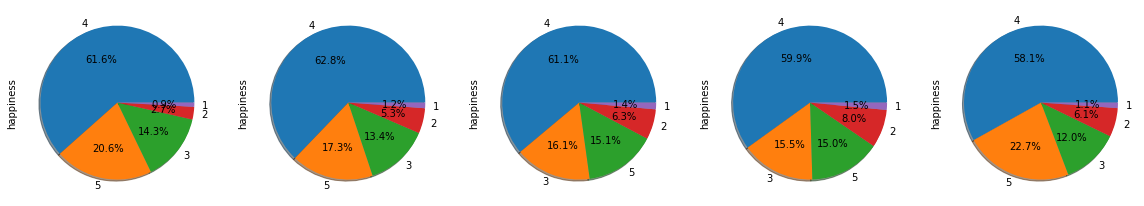

In [52]:
figure1,ax1 = plt.subplots(1,5,figsize=(20,6))
train['happiness'][train['Age']==1].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[0],shadow=True)
train['happiness'][train['Age']==2].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[1],shadow=True)
train['happiness'][train['Age']==3].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[2],shadow=True)
train['happiness'][train['Age']==4].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[3],shadow=True)
train['happiness'][train['Age']==5].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[4],shadow=True)

In [53]:
#查看特征的相关性
cols = train.corr().nlargest(20, 'happiness')['happiness'].index
cols

Index(['happiness', 'depression', 'health', 'class', 'equity', 'family_status',
       'health_problem', 'class_10_after', 'public_service_6',
       'public_service_7', 'public_service_5', 'public_service_3',
       'public_service_4', 'public_service_9', 'class_10_before',
       'public_service_8', 's_edu', 'public_service_2', 'relax',
       'public_service_1'],
      dtype='object')

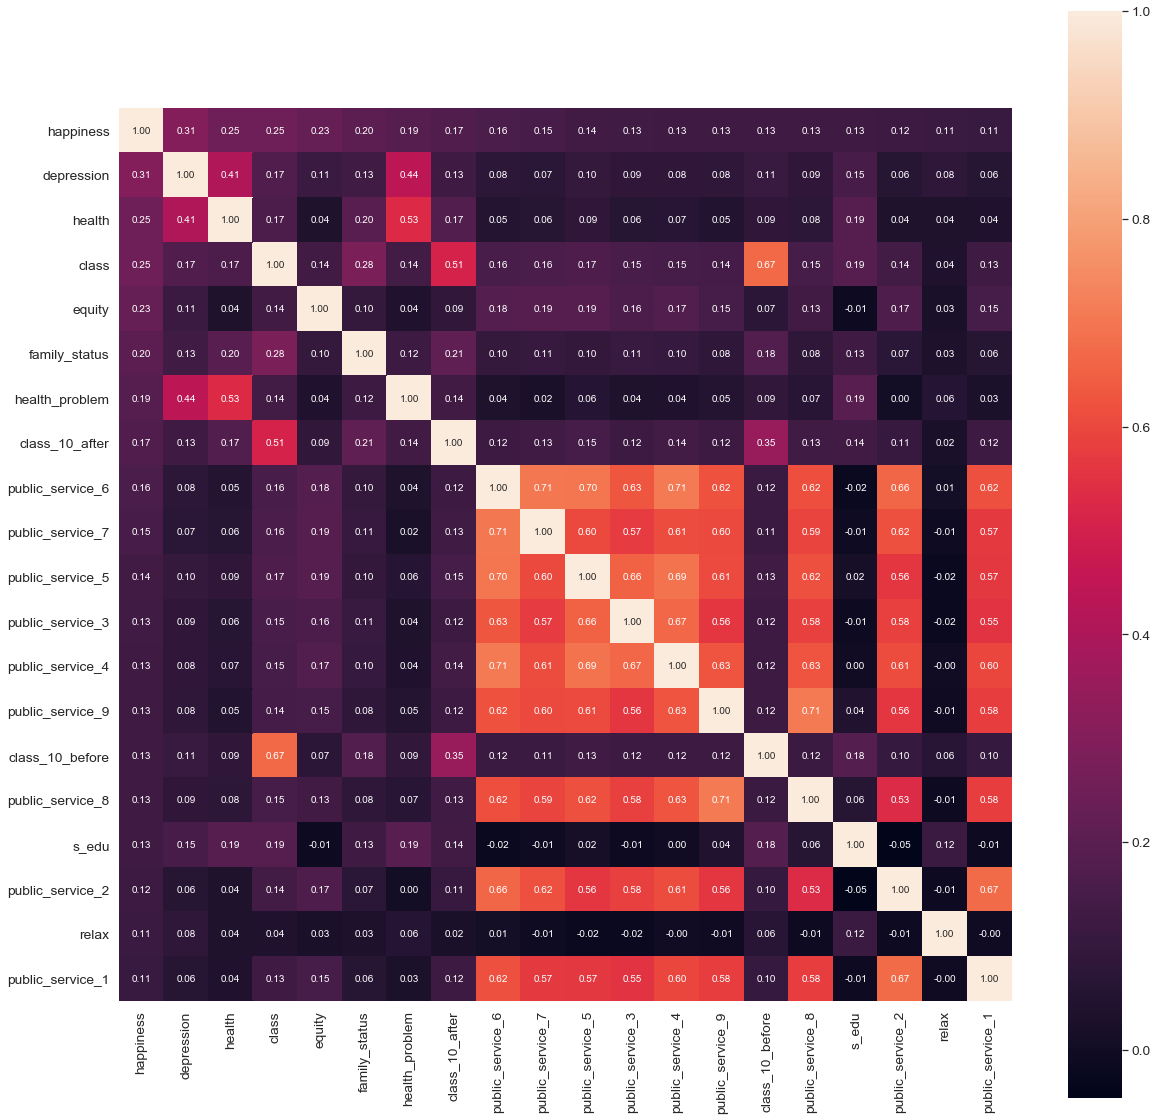

In [54]:
df_corr = pd.DataFrame(train[cols].values,columns=cols)
sns.set(font_scale=1.25)
f, ax= plt.subplots(figsize = (20, 20))
hm = sns.heatmap(df_corr.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,ax=ax)
plt.show()

In [65]:
#144+1 =145
data['survey_time'] = pd.to_datetime(data['survey_time'], format='%Y-%m-%d',errors='coerce')
data['survey_time'] = data['survey_time'].dt.year
data['age'] = data['survey_time']-data['birth']
#年龄分箱 145+1=146
bins = [0,17,26,34,50,63,100]
data['age_bin'] = pd.cut(data['age'], bins, labels=[0,1,2,3,4,5])
#对‘宗教’处理
data.loc[data['religion']<0,'religion'] = 1
data.loc[data['religion_freq']<0,'religion_freq'] = 1
#对‘教育程度’处理
data.loc[data['edu']<0,'edu'] = 4
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['edu_yr']<0,'edu_yr'] = 0
#对‘个人收入’处理
data.loc[data['income']<0,'income'] = 0
#对‘政治面貌’处理
data.loc[data['political']<0,'political'] = 1
#对体重处理
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2
#对身高处理
data.loc[data['height_cm']<150,'height_cm'] = 150
#对‘健康’处理
data.loc[data['health']<0,'health'] = 4
data.loc[data['health_problem']<0,'health_problem'] = 4
#对‘沮丧’处理
data.loc[data['depression']<0,'depression'] = 4
#对‘媒体’处理
data.loc[data['media_1']<0,'media_1'] = 1
data.loc[data['media_2']<0,'media_2'] = 1
data.loc[data['media_3']<0,'media_3'] = 1
data.loc[data['media_4']<0,'media_4'] = 1
data.loc[data['media_5']<0,'media_5'] = 1
data.loc[data['media_6']<0,'media_6'] = 1
#对‘空闲活动’处理
data.loc[data['leisure_1']<0,'leisure_1'] = 1
data.loc[data['leisure_2']<0,'leisure_2'] = 5
data.loc[data['leisure_3']<0,'leisure_3'] = 3
data.loc[data['leisure_4']<0,'leisure_4'] = data['leisure_4'].mode()
data.loc[data['leisure_5']<0,'leisure_5'] = data['leisure_5'].mode()
data.loc[data['leisure_6']<0,'leisure_6'] = data['leisure_6'].mode()
data.loc[data['leisure_7']<0,'leisure_7'] = data['leisure_7'].mode()
data.loc[data['leisure_8']<0,'leisure_8'] = data['leisure_8'].mode()
data.loc[data['leisure_9']<0,'leisure_9'] = data['leisure_9'].mode()
data.loc[data['leisure_10']<0,'leisure_10'] = data['leisure_10'].mode()
data.loc[data['leisure_11']<0,'leisure_11'] = data['leisure_11'].mode()
data.loc[data['leisure_12']<0,'leisure_12'] = data['leisure_12'].mode()
data.loc[data['socialize']<0,'socialize'] = 2
data.loc[data['relax']<0,'relax'] = 4
data.loc[data['learn']<0,'learn'] = 1
#对‘社交’处理
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0
data.loc[data['social_friend']<0,'social_friend'] = 0
data.loc[data['socia_outing']<0,'socia_outing'] = 1
data.loc[data['neighbor_familiarity']<0,'social_neighbor']= 4
#对‘社会公平性’处理
data.loc[data['equity']<0,'equity'] = 4
#对‘社会等级’处理
data.loc[data['class_10_before']<0,'class_10_before'] = 3
data.loc[data['class']<0,'class'] = 5
data.loc[data['class_10_after']<0,'class_10_after'] = 5
data.loc[data['class_14']<0,'class_14'] = 2
#对‘工作情况’处理
data.loc[data['work_status']<0,'work_status'] = 0
data.loc[data['work_yr']<0,'work_yr'] = 0
data.loc[data['work_manage']<0,'work_manage'] = 0
data.loc[data['work_type']<0,'work_type'] = 0
#对‘社会保障’处理
data.loc[data['insur_1']<0,'insur_1'] = 1
data.loc[data['insur_2']<0,'insur_2'] = 1
data.loc[data['insur_3']<0,'insur_3'] = 1
data.loc[data['insur_4']<0,'insur_4'] = 1
data.loc[data['insur_1']==0,'insur_1'] = 0
data.loc[data['insur_2']==0,'insur_2'] = 0
data.loc[data['insur_3']==0,'insur_3'] = 0
data.loc[data['insur_4']==0,'insur_4'] = 0

#对家庭情况处理
family_income_mean = data['family_income'].mean()
data.loc[data['family_income']<0,'family_income'] = family_income_mean
data.loc[data['family_m']<0,'family_m'] = 2
data.loc[data['family_status']<0,'family_status'] = 3
data.loc[data['house']<0,'house'] = 1
data.loc[data['car']<0,'car'] = 0
data.loc[data['car']==2,'car'] = 0
data.loc[data['son']<0,'son'] = 1
data.loc[data['daughter']<0,'daughter'] = 0
data.loc[data['minor_child']<0,'minor_child'] = 0
#对‘婚姻’处理
data.loc[data['marital_1st']<0,'marital_1st'] = 0
data.loc[data['marital_now']<0,'marital_now'] = 0
#对‘配偶’处理
data.loc[data['s_birth']<0,'s_birth'] = 0
data.loc[data['s_edu']<0,'s_edu'] = 0
data.loc[data['s_political']<0,'s_political'] = 0
data.loc[data['s_hukou']<0,'s_hukou'] = 0
data.loc[data['s_income']<0,'s_income'] = 0
data.loc[data['s_work_type']<0,'s_work_type'] = 0
data.loc[data['s_work_status']<0,'s_work_status'] = 0
data.loc[data['s_work_exper']<0,'s_work_exper'] = 0
#对‘父母情况’处理
data.loc[data['f_birth']<0,'f_birth'] = 1945
data.loc[data['f_edu']<0,'f_edu'] = 1
data.loc[data['f_political']<0,'f_political'] = 1
data.loc[data['f_work_14']<0,'f_work_14'] = 2
data.loc[data['m_birth']<0,'m_birth'] = 1940
data.loc[data['m_edu']<0,'m_edu'] = 1
data.loc[data['m_political']<0,'m_political'] = 1
data.loc[data['m_work_14']<0,'m_work_14'] = 2
#和同龄人相比社会经济地位
data.loc[data['status_peer']<0,'status_peer'] = 2
#和3年前比社会经济地位
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#对‘观点’处理
data.loc[data['view']<0,'view'] = 4
#对期望年收入处理
data.loc[data['inc_ability']<=0,'inc_ability']= 2
inc_exp_mean = data['inc_exp'].mean()
data.loc[data['inc_exp']<=0,'inc_exp']= inc_exp_mean

#部分特征处理
for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode().values
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode().values

#第一次结婚年龄 147
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄 148
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚 149
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄 150
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差 151
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比 151+7 =158
data['income/s_income'] = data['income']/(data['s_income']+1)
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)
data['income/m'] = data['income']/(data['family_m']+0.01)

#收入/面积比 158+4=162
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)
data['floor_area/m'] = data['floor_area']/(data['family_m']+0.01)

#class 162+3=165
data['class_10_diff'] = (data['class_10_after'] - data['class'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']
#悠闲指数 166
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum(axis=1) #skew
#满意指数 167
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_sum'] = data[public_service_fea_lis].sum(axis=1) #skew

#信任指数 168
trust_fea_lis = ['trust_'+str(i) for i in range(1,14)]
data['trust_sum'] = data[trust_fea_lis].sum(axis=1) #skew

#province mean 168+13=181
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values
data['province_health_mean'] = data.groupby(['province'])['health'].transform('mean').values
data['province_class_10_diff_mean'] = data.groupby(['province'])['class_10_diff'].transform('mean').values
data['province_class_mean'] = data.groupby(['province'])['class'].transform('mean').values
data['province_health_problem_mean'] = data.groupby(['province'])['health_problem'].transform('mean').values
data['province_family_status_mean'] = data.groupby(['province'])['family_status'].transform('mean').values
data['province_leisure_sum_mean'] = data.groupby(['province'])['leisure_sum'].transform('mean').values
data['province_public_service_sum_mean'] = data.groupby(['province'])['public_service_sum'].transform('mean').values
data['province_trust_sum_mean'] = data.groupby(['province'])['trust_sum'].transform('mean').values

#city   mean 181+13=194
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values
data['city_health_mean'] = data.groupby(['city'])['health'].transform('mean').values
data['city_class_10_diff_mean'] = data.groupby(['city'])['class_10_diff'].transform('mean').values
data['city_class_mean'] = data.groupby(['city'])['class'].transform('mean').values
data['city_health_problem_mean'] = data.groupby(['city'])['health_problem'].transform('mean').values
data['city_family_status_mean'] = data.groupby(['city'])['family_status'].transform('mean').values
data['city_leisure_sum_mean'] = data.groupby(['city'])['leisure_sum'].transform('mean').values
data['city_public_service_sum_mean'] = data.groupby(['city'])['public_service_sum'].transform('mean').values
data['city_trust_sum_mean'] = data.groupby(['city'])['trust_sum'].transform('mean').values

#county  mean 194 + 13 = 207
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values
data['county_health_mean'] = data.groupby(['county'])['health'].transform('mean').values
data['county_class_10_diff_mean'] = data.groupby(['county'])['class_10_diff'].transform('mean').values
data['county_class_mean'] = data.groupby(['county'])['class'].transform('mean').values
data['county_health_problem_mean'] = data.groupby(['county'])['health_problem'].transform('mean').values
data['county_family_status_mean'] = data.groupby(['county'])['family_status'].transform('mean').values
data['county_leisure_sum_mean'] = data.groupby(['county'])['leisure_sum'].transform('mean').values
data['county_public_service_sum_mean'] = data.groupby(['county'])['public_service_sum'].transform('mean').values
data['county_trust_sum_mean'] = data.groupby(['county'])['trust_sum'].transform('mean').values

#ratio 相比同省 207 + 13 =220
data['income/province'] = data['income']/(data['province_income_mean'])                                      
data['family_income/province'] = data['family_income']/(data['province_family_income_mean'])   
data['equity/province'] = data['equity']/(data['province_equity_mean'])       
data['depression/province'] = data['depression']/(data['province_depression_mean'])                                                
data['floor_area/province'] = data['floor_area']/(data['province_floor_area_mean'])
data['health/province'] = data['health']/(data['province_health_mean'])
data['class_10_diff/province'] = data['class_10_diff']/(data['province_class_10_diff_mean'])
data['class/province'] = data['class']/(data['province_class_mean'])
data['health_problem/province'] = data['health_problem']/(data['province_health_problem_mean'])
data['family_status/province'] = data['family_status']/(data['province_family_status_mean'])
data['leisure_sum/province'] = data['leisure_sum']/(data['province_leisure_sum_mean'])
data['public_service_sum/province'] = data['public_service_sum']/(data['province_public_service_sum_mean'])
data['trust_sum/province'] = data['trust_sum']/(data['province_trust_sum_mean']+1)

#ratio 相比同市 220 + 13 =233
data['income/city'] = data['income']/(data['city_income_mean'])                                      
data['family_income/city'] = data['family_income']/(data['city_family_income_mean'])   
data['equity/city'] = data['equity']/(data['city_equity_mean'])       
data['depression/city'] = data['depression']/(data['city_depression_mean'])                                                
data['floor_area/city'] = data['floor_area']/(data['city_floor_area_mean'])
data['health/city'] = data['health']/(data['city_health_mean'])
data['class_10_diff/city'] = data['class_10_diff']/(data['city_class_10_diff_mean'])
data['class/city'] = data['class']/(data['city_class_mean'])
data['health_problem/city'] = data['health_problem']/(data['city_health_problem_mean'])
data['family_status/city'] = data['family_status']/(data['city_family_status_mean'])
data['leisure_sum/city'] = data['leisure_sum']/(data['city_leisure_sum_mean'])
data['public_service_sum/city'] = data['public_service_sum']/(data['city_public_service_sum_mean'])
data['trust_sum/city'] = data['trust_sum']/(data['city_trust_sum_mean'])

#ratio 相比同个地区 233 + 13 =246
data['income/county'] = data['income']/(data['county_income_mean'])                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean'])   
data['equity/county'] = data['equity']/(data['county_equity_mean'])       
data['depression/county'] = data['depression']/(data['county_depression_mean'])                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean'])
data['health/county'] = data['health']/(data['county_health_mean'])
data['class_10_diff/county'] = data['class_10_diff']/(data['county_class_10_diff_mean'])
data['class/county'] = data['class']/(data['county_class_mean'])
data['health_problem/county'] = data['health_problem']/(data['county_health_problem_mean'])
data['family_status/county'] = data['family_status']/(data['county_family_status_mean'])
data['leisure_sum/county'] = data['leisure_sum']/(data['county_leisure_sum_mean'])
data['public_service_sum/county'] = data['public_service_sum']/(data['county_public_service_sum_mean'])
data['trust_sum/county'] = data['trust_sum']/(data['county_trust_sum_mean'])

#age   mean 246+ 13 =259
data['age_income_mean'] = data.groupby(['age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['age'])['health'].transform('mean').values
data['age_class_10_diff_mean'] = data.groupby(['age'])['class_10_diff'].transform('mean').values
data['age_class_mean'] = data.groupby(['age'])['class'].transform('mean').values
data['age_health_problem_mean'] = data.groupby(['age'])['health_problem'].transform('mean').values
data['age_family_status_mean'] = data.groupby(['age'])['family_status'].transform('mean').values
data['age_leisure_sum_mean'] = data.groupby(['age'])['leisure_sum'].transform('mean').values
data['age_public_service_sum_mean'] = data.groupby(['age'])['public_service_sum'].transform('mean').values
data['age_trust_sum_mean'] = data.groupby(['age'])['trust_sum'].transform('mean').values

# 和同龄人相比259 + 13 =272
data['income/age'] = data['income']/(data['age_income_mean'])                                      
data['family_income/age'] = data['family_income']/(data['age_family_income_mean'])   
data['equity/age'] = data['equity']/(data['age_equity_mean'])       
data['depression/age'] = data['depression']/(data['age_depression_mean'])                                                
data['floor_area/age'] = data['floor_area']/(data['age_floor_area_mean'])
data['health/age'] = data['health']/(data['age_health_mean'])
data['class_10_diff/age'] = data['class_10_diff']/(data['age_class_10_diff_mean'])
data['class/age'] = data['class']/(data['age_class_mean'])
data['health_problem/age'] = data['health_problem']/(data['age_health_problem_mean'])
data['family_status/age'] = data['family_status']/(data['age_family_status_mean'])
data['leisure_sum/age'] = data['leisure_sum']/(data['age_leisure_sum_mean'])
data['public_service_sum/age'] = data['public_service_sum']/(data['age_public_service_sum_mean'])
data['trust_sum/age'] = data['trust_sum']/(data['age_trust_sum_mean'])


print('shape',data.shape)
data.head()



shape (10956, 272)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,depression/age,floor_area/age,health/age,class_10_diff/age,class/age,health_problem/age,family_status/age,leisure_sum/age,public_service_sum/age,trust_sum/age
0,1,1,12,32,59,2015,1,1959,1,1,...,1.285211,0.410351,0.848837,0.000000,0.683307,0.521429,0.733668,0.724620,0.666638,0.925941
1,2,2,18,52,85,2015,1,1992,1,1,...,0.733333,0.952824,1.179337,1.012552,1.344444,0.891344,1.359551,1.011792,1.130778,1.188442
2,3,2,29,83,126,2015,2,1967,1,0,...,1.343537,0.972328,1.150485,1.190955,1.195762,1.055679,1.190955,0.966470,1.193204,0.803693
3,4,2,10,28,51,2015,2,1943,1,1,...,1.111663,0.642329,1.276353,4.977778,1.199143,1.188329,1.162630,0.899346,1.153810,1.300950
4,5,1,7,18,36,2015,2,1994,1,1,...,0.750000,0.587284,1.177106,0.000000,0.236957,1.116803,1.093645,1.045313,0.728161,1.117428


In [66]:
#272-9=263
del_list=['id','survey_time','edu_other','invest_other','property_other','join_party','province','city','county']
use_feature = [clo for clo in data.columns if clo not in del_list]
data.fillna(0,inplace=True)
train_shape = train.shape[0]
features = data[use_feature].columns
X_train_263 = data[:train_shape][use_feature].values
y_train = target
X_test_263 = data[train_shape:][use_feature].values
X_train_263.shape

(7988, 263)

In [67]:
imp_fea_49 = ['equity','depression','health','class','family_status','health_problem','class_10_after',
           'equity/province','equity/city','equity/county',
           'depression/province','depression/city','depression/county',
           'health/province','health/city','health/county',
           'class/province','class/city','class/county',
           'family_status/province','family_status/city','family_status/county',
           'family_income/province','family_income/city','family_income/county',
           'floor_area/province','floor_area/city','floor_area/county',
           'leisure_sum/province','leisure_sum/city','leisure_sum/county',
           'public_service_sum/province','public_service_sum/city','public_service_sum/county',
           'trust_sum/province','trust_sum/city','trust_sum/county',
           'income/m','public_service_sum','class_diff','status_3_before','family_income','floor_area',
           'weight_jin','height_cm',
           'health/age','depression/age','equity/age','leisure_sum/age'
          ]
train_shape = train.shape[0]
X_train_49 = data[:train_shape][imp_fea_49].values
X_test_49 = data[train_shape:][imp_fea_49].values
X_train_49.shape

(7988, 49)

In [68]:
cat_fea = ['survey_type','gender','nationality','edu_status','political','hukou','hukou_loc','work_exper','work_status','work_type',
           'work_manage','marital','s_political','s_hukou','s_work_exper','s_work_status','s_work_type','f_political','f_work_14',
           'm_political','m_work_14']
noc_fea = [clo for clo in use_feature if clo not in cat_fea]

len(noc_fea)

242

In [69]:
onehot_data = data[cat_fea].values
enc = preprocessing.OneHotEncoder(categories='auto')
oh_data=enc.fit_transform(onehot_data).toarray()
oh_data.shape

(10956, 141)

In [70]:
X_train_oh = oh_data[:train_shape,:]
X_test_oh = oh_data[train_shape:,:]
X_train_oh.shape

(7988, 141)

In [71]:
X_train_383 = np.column_stack([data[:train_shape][noc_fea].values,X_train_oh])
X_test_383 = np.column_stack([data[train_shape:][noc_fea].values,X_test_oh])
X_train_383.shape

(7988, 383)

In [124]:
##### lgb
param = {
'num_leaves': 8,
'min_data_in_leaf': 40,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.05,
"min_child_samples": 30,
"boosting": "gbdt",
"feature_fraction": 0.9,
"bagging_freq": 2,
"bagging_fraction": 0.8,
"bagging_seed": 2029,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)   
oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 500)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 500 rounds.
[500]	training's l2: 0.442073	valid_1's l2: 0.699473
Early stopping, best iteration is:
[1]	training's l2: 0.667807	valid_1's l2: 0.671103
fold n°2
Training until validation scores don't improve for 500 rounds.
[500]	training's l2: 0.439843	valid_1's l2: 0.694516
Early stopping, best iteration is:
[2]	training's l2: 0.667087	valid_1's l2: 0.671024
fold n°3
Training until validation scores don't improve for 500 rounds.
[500]	training's l2: 0.445515	valid_1's l2: 0.690975
Early stopping, best iteration is:
[41]	training's l2: 0.640981	valid_1's l2: 0.666138
fold n°4
Training until validation scores don't improve for 500 rounds.
[500]	training's l2: 0.446047	valid_1's l2: 0.692948
Early stopping, best iteration is:
[6]	training's l2: 0.664191	valid_1's l2: 0.668323
fold n°5
Training until validation scores don't improve for 500 rounds.
[500]	training's l2: 0.440238	valid_1's l2: 0.675546
Early stopping, best iteration

In [125]:
lgb_df = pd.DataFrame(predictions_lgb)
lgb_df.describe()

,0
count,2956.000000
mean,3.868056
std,0.020949
min,3.761429
25%,3.856025
50%,3.868883
75%,3.880881
max,3.951520


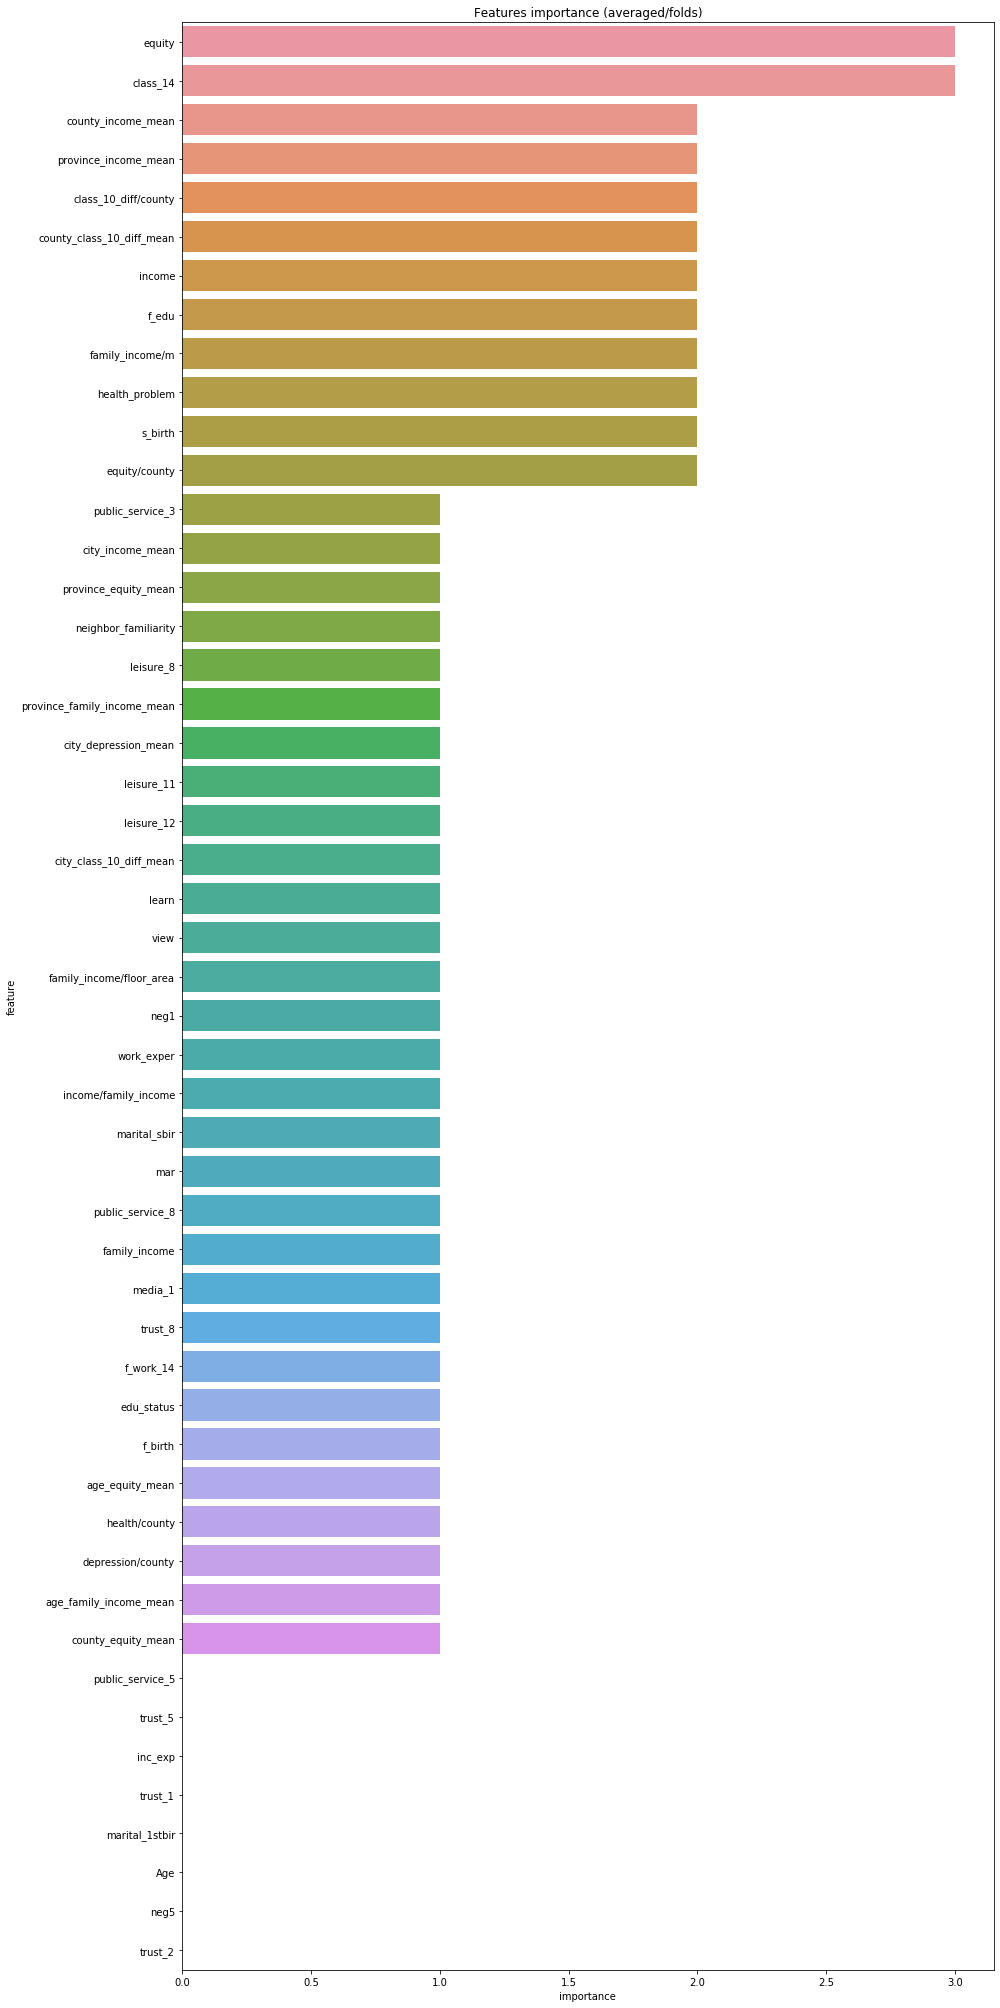

In [123]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_feature].columns.tolist(), columns=['feature'])
df['importance']=list(clf.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [79]:
new_label = target
new_label = new_label -1

0       3
1       3
2       3
3       4
4       3
5       4
6       3
7       3
8       3
9       3
10      3
11      3
12      3
13      1
14      3
15      3
16      3
17      3
18      3
19      4
20      3
21      4
22      3
23      3
24      3
25      3
26      4
27      3
28      2
29      4
       ..
7958    2
7959    3
7960    3
7961    4
7962    3
7963    2
7964    4
7965    3
7966    2
7967    3
7968    2
7969    3
7970    3
7971    4
7972    3
7973    3
7974    2
7975    2
7976    3
7977    3
7978    3
7979    3
7980    4
7981    3
7982    3
7983    1
7984    2
7985    3
7986    2
7987    3
Name: happiness, Length: 7988, dtype: int64

In [87]:
##### lgb_263
lgb_263_param = {
'num_leaves': 7,
'min_data_in_leaf': 20,
'objective':'multiclass',
'num_class':5,  
'max_depth': -1,
'learning_rate': 0.003,
"boosting": "gbdt",
"feature_fraction": 0.18,
"bagging_freq": 1,
"bagging_fraction": 0.55,
"bagging_seed": 14,
"metric": 'multi_logloss',
"lambda_l1": 0.1005,
"lambda_l2": 0.1996, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)   
oof_lgb_263 = np.zeros(len(X_train_263))
predictions_lgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, new_label)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_263[trn_idx], new_label[trn_idx])
    val_data = lgb.Dataset(X_train_263[val_idx], new_label[val_idx])

    num_round = 10000
    lgb_263 = lgb.train(lgb_263_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 800)
    oof_lgb_263[val_idx] = lgb_263.predict(X_train_263[val_idx], num_iteration=lgb_263.best_iteration).argmax(axis=1)
    predictions_lgb_263 += lgb_263.predict(X_test_263, num_iteration=lgb_263.best_iteration).argmax(axis=1) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_263, new_label)))

fold n°1
Training until validation scores don't improve for 800 rounds.
[500]	training's multi_logloss: 0.961371	valid_1's multi_logloss: 0.991979
[1000]	training's multi_logloss: 0.892938	valid_1's multi_logloss: 0.948926
[1500]	training's multi_logloss: 0.847244	valid_1's multi_logloss: 0.927215
[2000]	training's multi_logloss: 0.811636	valid_1's multi_logloss: 0.914519
[2500]	training's multi_logloss: 0.781985	valid_1's multi_logloss: 0.905955
[3000]	training's multi_logloss: 0.756177	valid_1's multi_logloss: 0.90047
[3500]	training's multi_logloss: 0.732957	valid_1's multi_logloss: 0.896704
[4000]	training's multi_logloss: 0.711642	valid_1's multi_logloss: 0.894244
[4500]	training's multi_logloss: 0.691787	valid_1's multi_logloss: 0.892349
[5000]	training's multi_logloss: 0.673293	valid_1's multi_logloss: 0.891069
[5500]	training's multi_logloss: 0.655743	valid_1's multi_logloss: 0.890321
[6000]	training's multi_logloss: 0.639129	valid_1's multi_logloss: 0.890052
[6500]	training's 

In [88]:
oof_lgb_263

array([3., 3., 3., ..., 3., 3., 3.])

In [116]:
##### lgb_49
lgb_49_param = {
'num_leaves': 7,
'min_data_in_leaf': 23,
'objective':'multiclass',
 'num_class':5, 
'max_depth': -1,
'learning_rate': 0.005,
"boosting": "gbdt",
"feature_fraction": 0.45,
"bagging_freq": 1,
"bagging_fraction": 0.65,
"bagging_seed": 15,
"metric": 'multi_logloss',
"lambda_l2": 0.2, 
"verbosity": -1}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)   
oof_lgb_49 = np.zeros(len(X_train_49))
predictions_lgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, new_label)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train_49[trn_idx], new_label[trn_idx])
    val_data = lgb.Dataset(X_train_49[val_idx], new_label[val_idx])

    num_round = 12000
    lgb_49 = lgb.train(lgb_49_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)
    oof_lgb_49[val_idx] = lgb_49.predict(X_train_49[val_idx], num_iteration=lgb_49.best_iteration).argmax(axis=1)
    predictions_lgb_49 += lgb_49.predict(X_test_49, num_iteration=lgb_49.best_iteration).argmax(axis=1) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb_49, new_label)))

fold n°1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's multi_logloss: 0.847738	valid_1's multi_logloss: 0.940693
[2000]	training's multi_logloss: 0.768712	valid_1's multi_logloss: 0.933177
[3000]	training's multi_logloss: 0.709583	valid_1's multi_logloss: 0.933722
Early stopping, best iteration is:
[2175]	training's multi_logloss: 0.757511	valid_1's multi_logloss: 0.932839
fold n°2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's multi_logloss: 0.843796	valid_1's multi_logloss: 0.952068
[2000]	training's multi_logloss: 0.76444	valid_1's multi_logloss: 0.943577
[3000]	training's multi_logloss: 0.705372	valid_1's multi_logloss: 0.94437
Early stopping, best iteration is:
[2287]	training's multi_logloss: 0.7462	valid_1's multi_logloss: 0.943083
fold n°3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's multi_logloss: 0.849765	valid_1's multi_logloss: 0.933175
[2000]	training's multi_logloss

In [92]:
oof_lgb_49

array([3., 3., 3., ..., 3., 3., 3.])

In [107]:
##### xgb_263
xgb_263_params = {'eta': 0.03, 
              'max_depth': 6, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.3, 
              'lambda':2,
              'objective': 'multi:softmax',
              'num_class':5,
              'eval_metric': 'mlogloss', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_263 = np.zeros(len(X_train_263))
predictions_xgb_263 = np.zeros(len(X_test_263))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_263, new_label)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_263[trn_idx], new_label[trn_idx])
    val_data = xgb.DMatrix(X_train_263[val_idx], new_label[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_263 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=400, verbose_eval=500, params=xgb_263_params)
    oof_xgb_263[val_idx] = xgb_263.predict(xgb.DMatrix(X_train_263[val_idx]), ntree_limit=xgb_263.best_ntree_limit)
    predictions_xgb_263 += xgb_263.predict(xgb.DMatrix(X_test_263), ntree_limit=xgb_263.best_ntree_limit)/ folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_263, new_label)))

fold n°1
[0]	train-mlogloss:1.58048	valid_data-mlogloss:1.58426
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 400 rounds.
[500]	train-mlogloss:0.274912	valid_data-mlogloss:0.943587
Stopping. Best iteration:
[333]	train-mlogloss:0.383854	valid_data-mlogloss:0.93245

fold n°2
[0]	train-mlogloss:1.58061	valid_data-mlogloss:1.5853
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 400 rounds.
[500]	train-mlogloss:0.272848	valid_data-mlogloss:0.966568
Stopping. Best iteration:
[274]	train-mlogloss:0.436118	valid_data-mlogloss:0.956053

fold n°3
[0]	train-mlogloss:1.58152	valid_data-mlogloss:1.5848
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 400 rounds.
[500]	train-mlogloss:0.277891

In [97]:
oof_xgb_263

array([3., 3., 3., ..., 3., 3., 3.])

In [100]:
##### xgb_49
xgb_49_params = {'eta': 0.03, 
              'max_depth': 5, 
              'min_child_weight':3,
              'gamma':0,
              'subsample': 0.7, 
              'colsample_bytree': 0.4, 
              'lambda':2,
              'objective': 'multi:softmax',
              'num_class':5,
              'eval_metric': 'mlogloss', 
              'silent': True, 
              'nthread': -1}


folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb_49 = np.zeros(len(X_train_49))
predictions_xgb_49 = np.zeros(len(X_test_49))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_49, new_label)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train_49[trn_idx],new_label[trn_idx])
    val_data = xgb.DMatrix(X_train_49[val_idx], new_label[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    xgb_49 = xgb.train(dtrain=trn_data, num_boost_round=3000, evals=watchlist, early_stopping_rounds=600, verbose_eval=500, params=xgb_49_params)
    oof_xgb_49[val_idx] = xgb_49.predict(xgb.DMatrix(X_train_49[val_idx]), ntree_limit=xgb_49.best_ntree_limit)
    predictions_xgb_49 += xgb_49.predict(xgb.DMatrix(X_test_49), ntree_limit=xgb_49.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb_49, new_label)))

fold n°1
[0]	train-mlogloss:1.58232	valid_data-mlogloss:1.58431
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 600 rounds.
[500]	train-mlogloss:0.486803	valid_data-mlogloss:0.969014
Stopping. Best iteration:
[298]	train-mlogloss:0.607828	valid_data-mlogloss:0.956787

fold n°2
[0]	train-mlogloss:1.58205	valid_data-mlogloss:1.58555
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 600 rounds.
[500]	train-mlogloss:0.489137	valid_data-mlogloss:0.967133
Stopping. Best iteration:
[387]	train-mlogloss:0.552761	valid_data-mlogloss:0.963633

fold n°3
[0]	train-mlogloss:1.58269	valid_data-mlogloss:1.58424
Multiple eval metrics have been passed: 'valid_data-mlogloss' will be used for early stopping.

Will train until valid_data-mlogloss hasn't improved in 600 rounds.
[500]	train-mlogloss:0.501

In [108]:
folds = KFold(n_splits=5, shuffle=True, random_state=13)
oof_lr_383 = np.zeros(train_shape)
predictions_lr_383 = np.zeros(len(X_test_383))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_383, new_label)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train_383[trn_idx]
    tr_y = new_label[trn_idx]
    lr_383 = LogisticRegression(random_state=0, solver='sag',multi_class='ovr')
    lr_383.fit(tr_x,tr_y)
    oof_lr_383[val_idx] = lr_383.predict(X_train_383[val_idx])
    
    predictions_lr_383 += lr_383.predict(X_test_383) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lr_383, new_label)))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
CV score: 0.68840761


In [102]:
oof_lr_383

array([3., 3., 3., ..., 3., 3., 3.])

In [103]:
result_stack = np.vstack([oof_lgb_263,oof_lgb_49,oof_xgb_263,oof_xgb_49,oof_lr_383]).transpose()
result_stack

array([[3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.],
       ...,
       [3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3.]])

In [111]:
df_result = pd.DataFrame(result_stack)
vote_result = df_result.mode(axis=1)

In [105]:
mean_squared_error(vote_result, target)

14.85478217325989

In [113]:
result = vote_result[0].values

In [114]:
result

array([3., 3., 3., ..., 3., 3., 3.])

In [115]:
mean_squared_error(result, new_label)

0.5824987481221833

In [117]:
train_stack3 = np.vstack([oof_lgb_263,oof_lgb_49,oof_xgb_263,oof_xgb_49,oof_lr_383]).transpose()
test_stack3 = np.vstack([predictions_lgb_263,predictions_lgb_49,predictions_xgb_263,predictions_xgb_49,predictions_lr_383]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=7)
oof_stack3 = np.zeros(train_stack3.shape[0])
predictions_lr3 = np.zeros(test_stack3.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack3,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack3[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack3[val_idx], target.iloc[val_idx].values
    
    lr3 = lr()
    lr3.fit(trn_data, trn_y)
    
    oof_stack3[val_idx] = lr3.predict(val_data)
    predictions_lr3 += lr3.predict(test_stack3) / 10
    
mean_squared_error(target.values, oof_stack3) 


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.5251511643615407

In [118]:
oof_stack3

array([3.91010628, 3.91010628, 3.92111832, ..., 3.91696434, 3.92831231,
       3.92111832])